# Training Script 
This notebook uses the different algorithms for training

In [5]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)


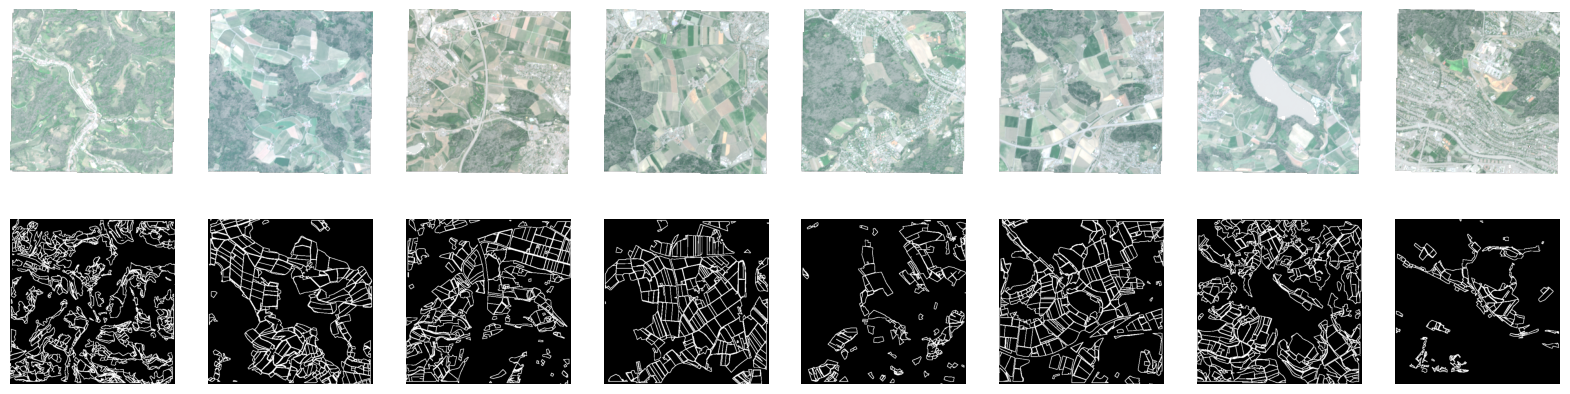

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_images(images, masks, num_images=8):
    fig, ax = plt.subplots(2, num_images, figsize=(20, 5))
    for i in range(num_images):
        ax[0, i].imshow(images[i])
        ax[0, i].axis('off')
        ax[1, i].imshow(masks[i].squeeze(), cmap='gray')
        ax[1, i].axis('off')
    plt.show()
    
path = "/workspaces/Satelite/data/dataset_upscaled_False/train"
train_data = tf.data.Dataset.load(path)

# Load the images and masks
images = []
masks = []

for image, mask in train_data.take(8):
    print(image.shape, mask.shape)
    images.append(image.numpy())
    masks.append(mask.numpy())

# Plot the images and masks
plot_images(images, masks, num_images=8)

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from helpers.load import LoadandAugment
from models import model

input_shape = (256,256,4)
UNET = model.Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0, batch_norm=True)

# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
train_path = os.path.join(path, "train")
val_path = os.path.join(path, "val")
test_path = os.path.join(path, "test")

# Initialize data loaders with correct target shape
train_data = LoadandAugment(train_path, "train", 8, True)
val_data = LoadandAugment(val_path, "val", 8, True)

# Initialize UNET model with correct input shape
UNET.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])

# Setup the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

# Train the model
UNET.fit(
    train_data.dataset, 
    validation_data=val_data.dataset, 
    epochs=100, 
    callbacks=[checkpoint_callback]
)


Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_63 (Conv2D)             (None, 256, 256, 64  2368        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_63 (BatchN  (None, 256, 256, 64  256        ['conv2d_63[0][0]']              
 ormalization)                  )                                                  

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 2156, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 5707, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 256, 256, 1) vs (None, 512, 512, 1)).


1/1 [==============================] - 0s 178ms/step
Min prediction value: 0.0
Max prediction value: 1.0


IndexError: index 5 is out of bounds for axis 0 with size 5

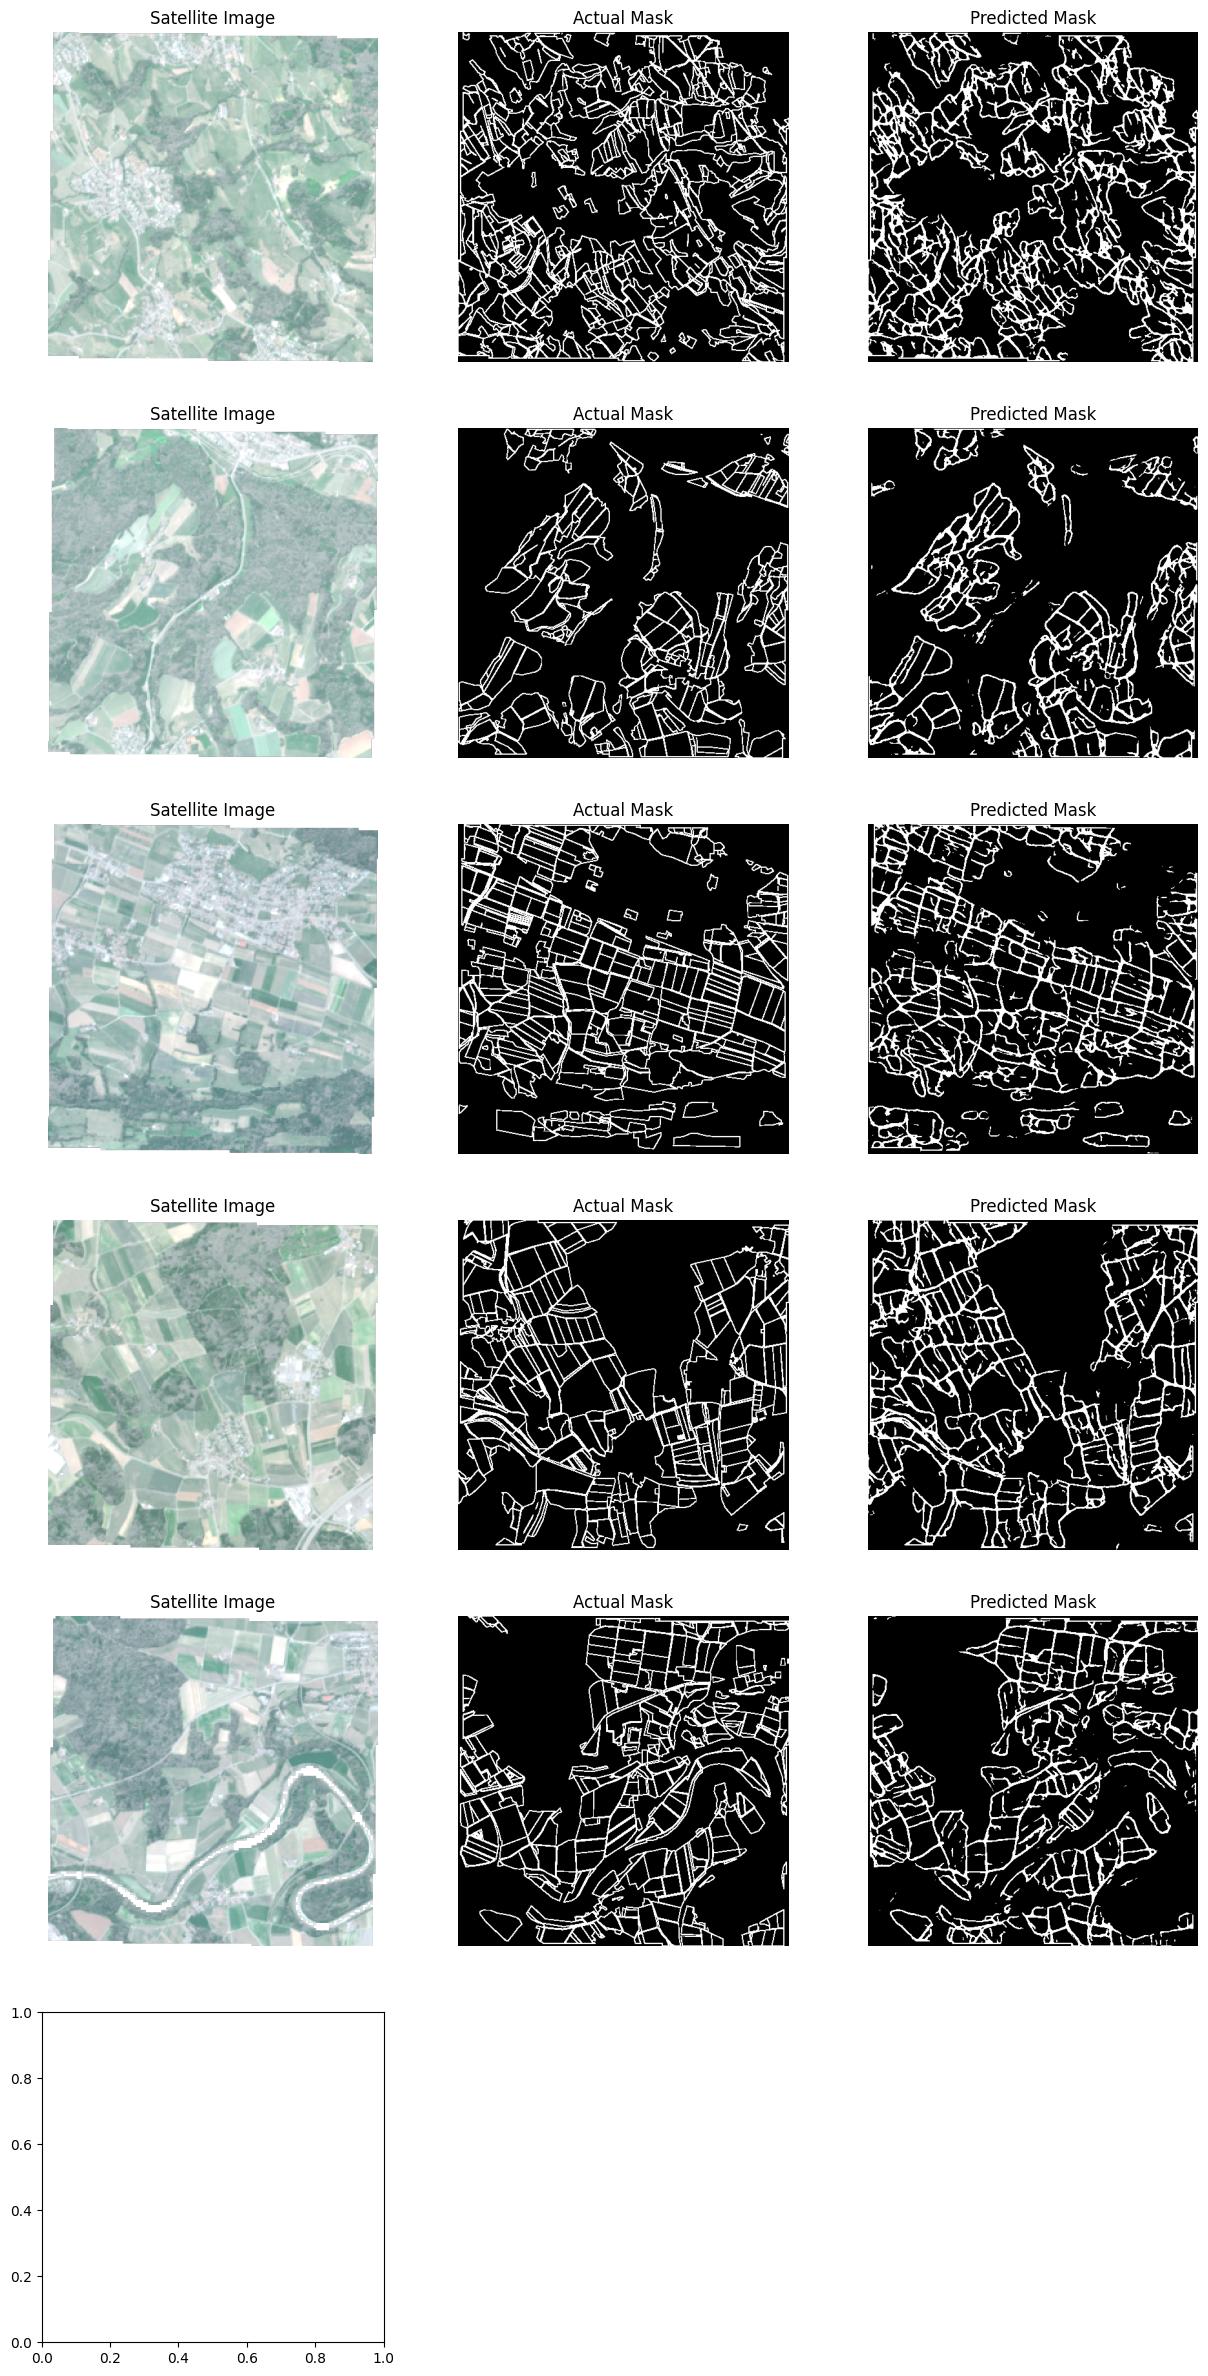

In [4]:

import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from models.RESUNETs import AttentionUNet
from helpers.load import LoadandAugment


# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
test_path = os.path.join(path, "test")

def plot_predictions(images, masks, predictions, num=6):
    plt.figure(figsize=(15, 5*num))
    
    for i in range(num):
        plt.subplot(num, 3, i*3+1)
        plt.imshow(images[i])
        plt.title("Satellite Image")
        plt.axis('off')
        
        plt.subplot(num, 3, i*3+2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        plt.subplot(num, 3, i*3+3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

UNET.load_weights('best_model.h5')

test_data_loader = LoadandAugment(test_path, "test", 5, True)

# Get the test dataset
test_dataset = test_data_loader.dataset

# Predict on the test data
for images, masks in test_dataset.take(1):
    predictions = UNET.predict(images)
    predictions = (predictions > 0.5).astype(np.float32) 

# Check predictions
print("Min prediction value:", predictions.min())
print("Max prediction value:", predictions.max())

# Plot the predictions
plot_predictions(images.numpy(), masks.numpy(), predictions)
